### Desafío - Dimensionalidad y Agrupación (I)

<br>
<br>

Nombre: **Nicolás Gómez**

Profesor: Gabriel Tamayo

Generación: **G2**


* Para poder realizar esta actividad debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip


### Contexto

Para esta actividad utilizaremos un subconjunto de 25 items de la International Personality Item Pool, aplicados a 2800 individuos. El objetivo de esta información es desarrollar perfiles de personalidad en base a una serie de oraciones asociadas a las características Amabilidad, Escrupolisidad, Extroversión, Neuroticismo, Apertura. Los individuos deben responder qué tan adecuada es la oración respecto a su personalidad en base a 6 categorías:
* 1: No me representa para nada.
* 2: No me representa.
* 3: Algunas cosas no me representan.
* 4: Algunas cosas me representan.
* 5: Me representa.
* 6: Me representa completamente.

Las 25 preguntas son:
* A1 Soy indiferente a los sentimientos de otros.
* A2 Me preocupo del bienestar de otros.
* A3 Sé cómo confortar a otros.
* A4 Me agradan los niños.
* A5 Hago sentir tranquila a la gente.
* C1 Soy exacto en mi trabajo.
* C2 Sigo con mis tareas hasta que todo esté perfecto.
* C3 Hago cosas siguiendo un plan.
* C4 Hago cosas con el mínimo esfuerzo.
* C5 Pierdo mi tiempo.
* E1 No hablo mucho con las personas.
* E2 Me es dificil acercarme a otros.
* E3 Sé cómo cautivar gente.
* E4 Hago amigos de forma fácil.
* E5 Puedo tomar el cargo de las cosas.
* N1 Me enojo con facilidad.
* N2 Me irrito con facilidad.
* N3 Tengo cambios de humor frecuentes.
* N4 Usualmente me siento melancólico.
* N5 Entro en pánico con facilidad.
* O1 Estoy lleno de ideas.
* O2 Evito leer material difícil.
* O3 Tiendo a llevar la conversación a niveles más altos.
* O4 Dedico tiempo a la reflexión de cosas.
* O5 No profundizaré sobre una materia específica.

Se registraron una serie de covariables sobre características demográficas de los encuestados:
* gender Hombre = 1, Mujer =2.
* education 1 = Educación Media Incompleta, 2 = Educación Media Completa, 3 = Educación Universitaria Incompleta, 4 = Educación Universitaria Completa 5 = Estudios de Postgrado.
* age Edad en Años.


Implementaremos un modelo de extracción factorial para identificar los principales perfiles
psicológicos.


### Desafío 1: Lectura de archivos

Importe las librerías necesarias para el análisis factorial siguiendo las convenciones.
Importe la base de datos bfi.csv y asígnela a un objeto df.
Solicite las primeras 5 observaciones con head.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, confusion_matrix,roc_auc_score
import factor_analyzer as factor
import missingno as msngo
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('bfi.csv')

In [3]:
df.head(5)

,Unnamed: 0,A1,A2,A3,A4,A5,C1,C2,C3,C4,...,N4,N5,O1,O2,O3,O4,O5,gender,education,age
0,61617,2.0,4.0,3.0,4.0,4.0,2.0,3.0,3.0,4.0,...,2.0,3.0,3.0,6,3.0,4.0,3.0,1,NaN,16
1,61618,2.0,4.0,5.0,2.0,5.0,5.0,4.0,4.0,3.0,...,5.0,5.0,4.0,2,4.0,3.0,3.0,2,NaN,18
2,61620,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,2.0,...,2.0,3.0,4.0,2,5.0,5.0,2.0,2,NaN,17
3,61621,4.0,4.0,6.0,5.0,5.0,4.0,4.0,3.0,5.0,...,4.0,1.0,3.0,3,4.0,3.0,5.0,2,NaN,17
4,61622,2.0,3.0,3.0,4.0,5.0,4.0,4.0,5.0,3.0,...,4.0,3.0,3.0,3,4.0,3.0,3.0,1,NaN,17


### Desafío 2: Preprocesamiento
* Elimine las columnas redundantes de la base, tal como 'Unnamed: 0' .
* Analice el patrón de datos perdidos con missingno . Comente cuáles son las principales variables con mayores tasas de valores perdidos.
* Genere un nuevo objeto donde almacenará la base sin valores perdidos.

In [4]:
df = df.drop('Unnamed: 0', axis = 1)

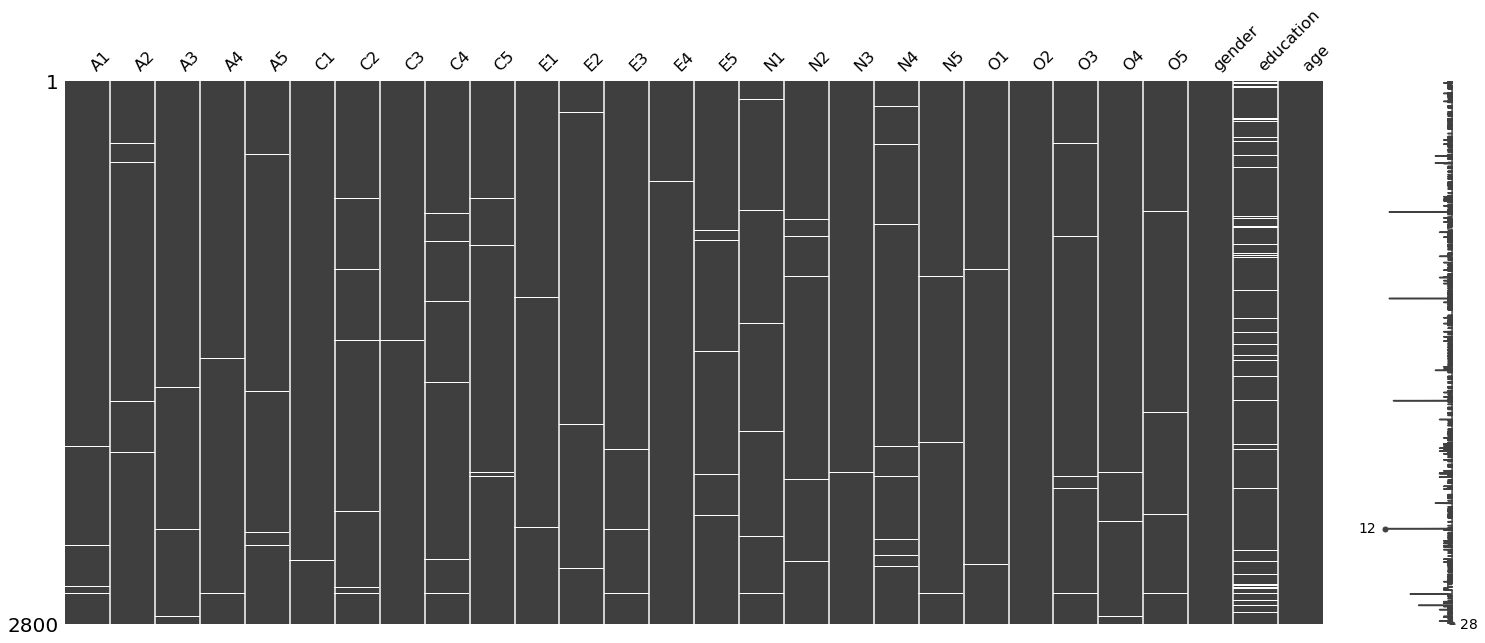

In [5]:
msngo.matrix(df);

En base al gráfico, `education` es el que tiene una mayor cantidad de datos perdidos.

El resto se ve balanceado.

Al confirmar analyzando el DF:

In [6]:
df.isna().sum().sort_values(ascending=False).head(5)

education    223
N4            36
N5            29
O3            28
A2            27
dtype: int64

Sí, `education` es claramente el que tiene mayor de datos perdidos.

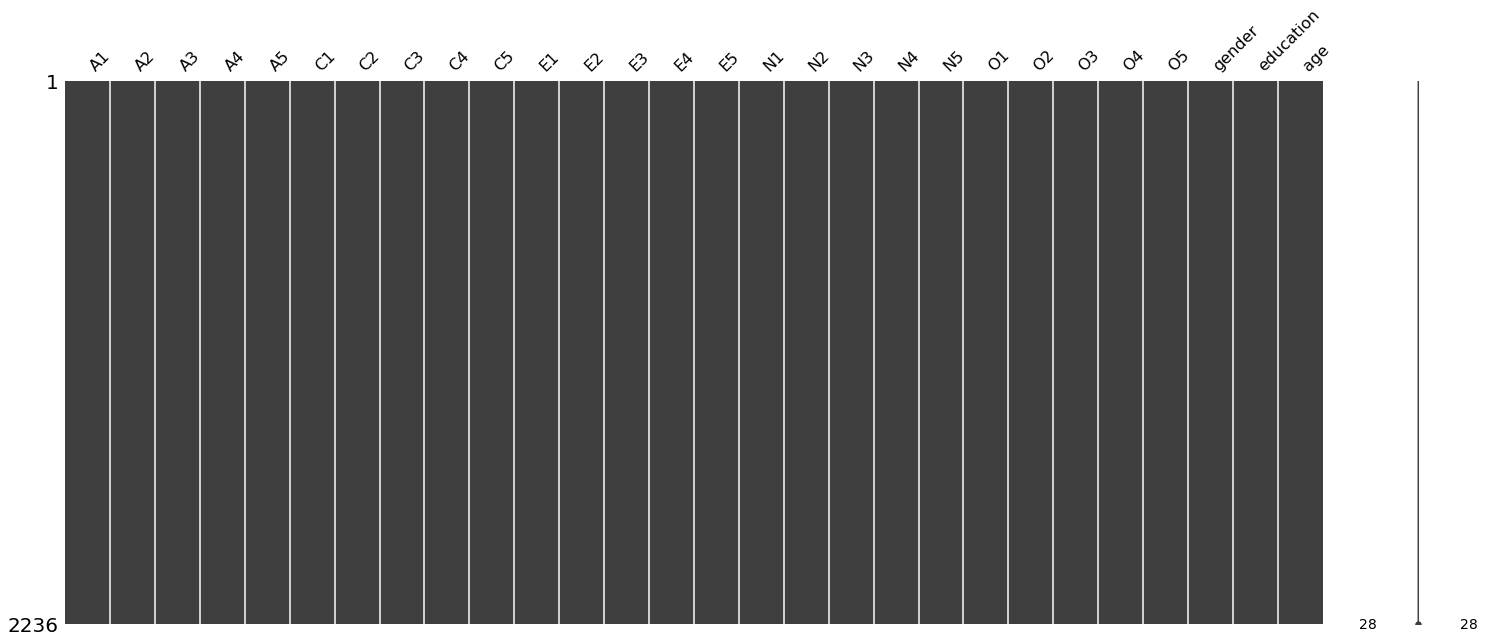

In [7]:
df_final = df.dropna()
msngo.matrix(df_final);

### Desafío 3: Descripción
* Separe en un nuevo objeto DataFrame la batería de preguntas a extraer.
* Reporte las medias para cada uno de las preguntas de la batería. Esto lo puede lograr con un dotplot.
* Genere una matriz de correlaciones con este nuevo objeto. Visualícelo con heatmap .
* Comente sobre los principales patrones de correlación entre las preguntas de la batería.

In [8]:
df_questions = df_final.loc[:, 'A1':'O5']

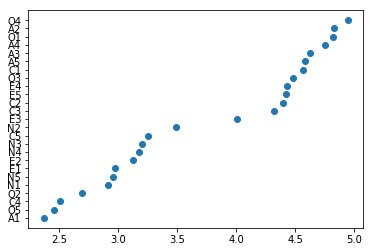

In [9]:
def plot_column_mean(df):
    columns = []
    mean = []

    for colname, serie in df.iteritems():
        columns.append(colname)
        mean.append(serie.mean())

    df_means = pd.DataFrame({'var': columns, 'mean': mean}).sort_values(by=['mean'])
    plt.plot(df_means['mean'], df_means['var'],'o')

plot_column_mean(df_questions)

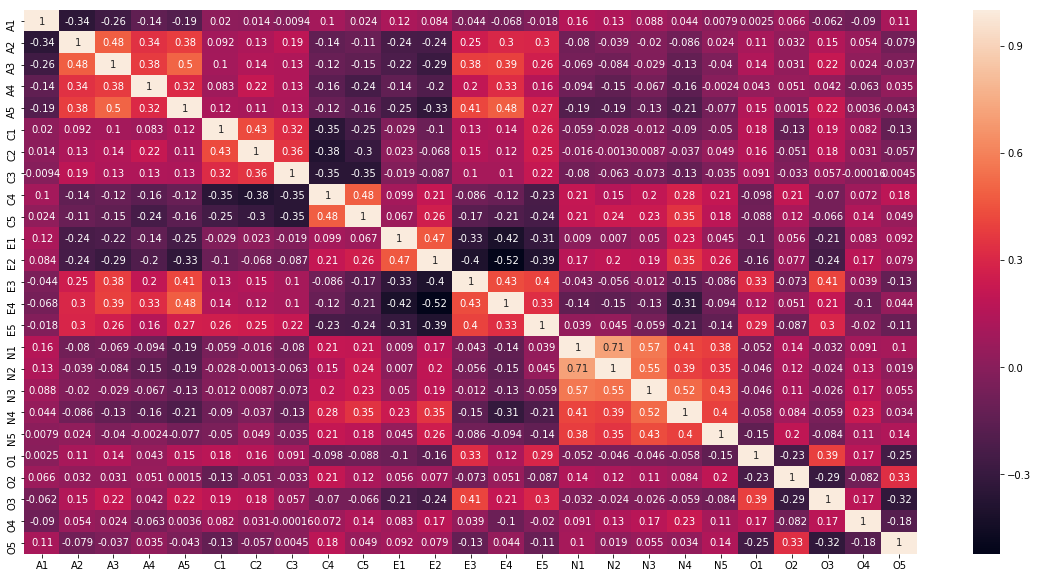

In [10]:
correlations = df_questions.corr()

plt.figure(figsize=(20,10))
sns.heatmap(correlations, annot=True)

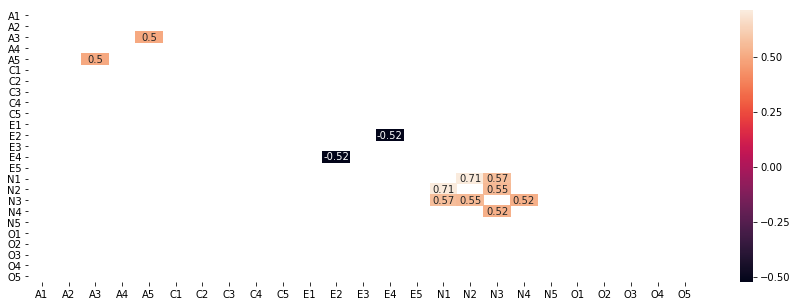

In [11]:
# Las principales las podemos filtrar
best_threshold = 0.5
best = correlations[((correlations > best_threshold) & (correlations < 1)) | (correlations < -best_threshold)]
plt.figure(figsize=(15,5))
sns.heatmap(best, annot=True)

Aquí podemos ver las principales correlaciones:

- N1 con N2
- N1 con N3
- N2 con N3
- N3 con N4
- A3 con E5

E inversamente:

- E2 con E4

### Desafío 4: Extracción de factores
* Antes de iniciar la extracción de factores, inspeccione la ideonidad de la batería de preguntas para realizar un análisis factorial mediante la prueba de esferacidad de Barlett y Kaiser-MeyerOlkin. Comente los resultados.
* Instancie un objeto con FactorAnalyzer() donde se estimen 10 dimensiones latentes y no se aplique rotación.
* Genere un scree plot entre los eigenvalues del modelo y la cantidad de dimensiones estimables.
* Refactorice el objeto con FactorAnalyzer() con rotacion (rotacion = 'promax') y la cantidad de dimensiones válidas que informó el scree plot.
* Extraiga las cargas del modelo e identifique qué items están asociados a cada factor. Comente sobre qué significa cada factor construído.

In [12]:
# Prueba de esferacidad de Barlett

factor.calculate_bartlett_sphericity(df_questions)

(16484.781654160415, 0.0)

En este caso, la prueba de esferacidad de errores sugiere que la matriz de
correlaciones no es igual a la matriz de identidad, por lo que se puede seguir con el análisis.

In [13]:
# Prueba de muestreo Kaiser-Meyer-Olkin (KMO)
factor.calculate_kmo(df_questions)

(         KMO
 A1  0.738005
 A2  0.834387
 A3  0.871681
 A4  0.870525
 A5  0.900699
 C1  0.838225
 C2  0.788569
 C3  0.849578
 C4  0.823776
 C5  0.861994
 E1  0.841634
 E2  0.883987
 E3  0.893156
 E4  0.878282
 E5  0.894127
 N1  0.778281
 N2  0.778607
 N3  0.860167
 N4  0.886345
 N5  0.860604
 O1  0.855123
 O2  0.783962
 O3  0.833868
 O4  0.781271
 O5  0.758213, 0.8469455121781353)

El resultado del test es $0.85 > 0.7$ así que podemos continuar con el análisis factorial.

No hay ningún valor menor a $0.7$

In [14]:
def factorize(df, n_factors, rotation=None):

    # Generamos una nueva instancia en el objeto factorize
    factor_analyzer = factor.FactorAnalyzer()

    # Implementamos el análisis
    factor_analyzer.analyze(data=df, n_factors=n_factors, rotation=rotation)

    # extraemos los eigenvalues
    factor_screeplot = factor_analyzer.get_eigenvalues()[0]

    # graficamos los eigenvalues contra la cantidad de dimensiones estimables
    plt.plot(factor_screeplot.index + 1, factor_screeplot.values, 'o-', color='tomato')
    plt.xlabel('Número de Factor')
    plt.ylabel('Valores Propios')

    # visualizamos el criterio de corte
    plt.axhline(1)
    plt.title("Scree plot")

    return factor_analyzer

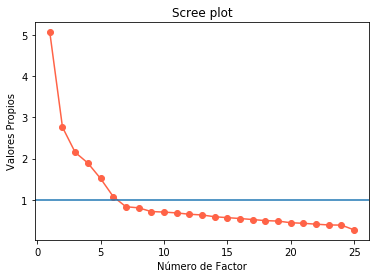

In [15]:
factorize(df_questions, 10)

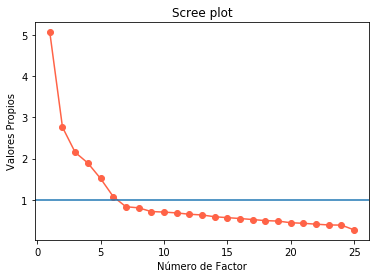

In [29]:
refactorize = factorize(df_questions, 6, 'promax')

In [30]:
refactorize.loadings.applymap(lambda x: np.where(x < .4, ' ', round(x, 2)))

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
A1,,,,,,
A2,,,,,0.64,
A3,,,,,0.49,
A4,,,,,,
A5,,,,,,
C1,,,0.59,,,
C2,,,0.74,,,
C3,,,0.61,,,
C4,,,,,,0.48
C5,,,,,,


De aquí podemos ver que:
    
- `Factor 1` está asociado a las preguntas "E"
- `Factor 2` está asociado a las preguntas "N"
- `Factor 3` está asociado a las preguntas "C"
- `Factor 4` está asociado a las preguntas "O"
- `Factor 5` está asociado a las preguntas "A"
- `Factor 6` está asociada a las preguntas "C" (C4)

Por lo tanto:

- `Factor 1` está asociado a habilidades sociales.
- `Factor 2` está asociado a autocontrol.
- `Factor 3` está asociado a organización.
- `Factor 4` está asociado a la motivación por estudiar.
- `Factor 5` está asociado a las preguntas de empatía.
- `Factor 6` está asociado a moverse por el mínimo esfuerzo.

### Desafío 5: Modelación de factores
* Extraiga los puntajes del modelo factorial a su base de datos.
*  Modele y comente brevemente sobre cuáles son los principales determinantes de cada factor en base al siguiente modelo estimable:


$${y}={{\beta }_{0} + {\beta }_{1} \cdot {gender} + {\beta }_{2} \cdot {education} + {\beta }_{3} \cdot {age} +{\epsilon}_{i}}$$


<br>
Tips: Utilice statsmodels para la generación del modelo y comente que tan significativos son los regresores, estos  afectan positiva o negativamente el factor estimado?.


In [45]:
scores = factorize_model.get_scores(df_questions)
scores

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
0,1.278885,0.000082,1.456887,-0.345082,-0.075712,0.197475
1,-1.772896,0.847953,-1.511354,0.259958,-1.933897,-1.439791
2,0.214861,-0.170602,-0.245800,0.368220,-0.216188,-0.152733
3,-0.074272,-0.324171,0.336115,0.179683,-1.579546,-0.938386
4,0.226235,-0.879940,-1.347676,-0.325794,0.717053,-0.142754
5,0.315466,0.993684,0.042760,-0.702200,0.906063,1.080357
6,0.991769,-0.807666,1.047575,-0.625346,-0.129771,-0.063051
7,1.648556,-1.045418,0.235199,-0.381786,0.609304,-0.380531
8,-0.313600,0.142791,0.950582,-1.487791,-0.609740,-0.572980
9,0.453400,-0.434891,-0.415034,0.045142,-0.511701,-0.829512


In [44]:
df_with_factors = df_final.copy(deep=True).dropna()

for colname, col in scores.iteritems():
    df_with_factors[colname] = col

df_with_factors

,A1,A2,A3,A4,A5,C1,C2,C3,C4,C5,...,O5,gender,education,age,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6
5,6.0,6.0,5.0,6.0,5.0,6.0,6.0,6.0,1.0,3.0,...,1.0,2,3.0,21,0.315466,0.993684,0.042760,-0.702200,0.906063,1.080357
7,4.0,3.0,1.0,5.0,1.0,3.0,2.0,4.0,2.0,4.0,...,3.0,1,2.0,19,1.648556,-1.045418,0.235199,-0.381786,0.609304,-0.380531
10,4.0,4.0,5.0,6.0,5.0,4.0,3.0,5.0,3.0,2.0,...,3.0,1,1.0,21,0.989694,0.614414,-0.324259,-0.291591,-0.131244,1.066071
14,4.0,5.0,2.0,2.0,1.0,5.0,5.0,5.0,2.0,2.0,...,5.0,1,1.0,17,-1.684468,-0.388122,0.160753,0.172218,0.570324,-0.048471
22,1.0,5.0,6.0,5.0,6.0,4.0,3.0,2.0,4.0,5.0,...,2.0,1,5.0,68,-0.827185,0.848514,-1.044274,0.391165,-1.162586,-0.213656
23,2.0,6.0,5.0,6.0,5.0,3.0,5.0,6.0,3.0,6.0,...,1.0,2,2.0,27,-0.217917,0.006652,-1.647958,0.361287,0.253071,-0.548452
24,4.0,5.0,5.0,6.0,5.0,5.0,5.0,4.0,1.0,1.0,...,2.0,1,1.0,18,-0.959781,1.188845,-0.189633,0.373227,-0.275533,-0.728576
25,1.0,6.0,6.0,1.0,6.0,5.0,2.0,5.0,1.0,1.0,...,3.0,2,3.0,20,1.842675,-0.448202,0.895613,-0.981294,0.914370,0.063469
26,2.0,4.0,4.0,4.0,3.0,6.0,5.0,6.0,1.0,1.0,...,1.0,2,5.0,51,0.337529,1.448951,-1.070900,0.035644,0.735269,-0.238825
28,2.0,5.0,1.0,3.0,5.0,5.0,4.0,5.0,2.0,5.0,...,1.0,2,3.0,33,1.078323,-1.125509,-0.038387,0.284559,-0.266002,-0.483898
